In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
import os
os.chdir('../../')

from modules import preproc
from modules.join_data import join_y
from modules import feature_eng
from modules import cluster_intelligence
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_rows',150)
pd.set_option('display.max_columns',1000)

In [2]:
print(os.getcwd())

c:\Users\Rory\Desktop\projects\expenditure_prox


## Reading in data and preproc

In [2]:
df = pd.read_json('full_data/smartphones.json')
df = join_y(df, 'raw_data/phone_sales.csv')
df = preproc.clean_cols(df)
df = preproc.fill_empty_lists(df)
df = preproc.preprocess_reviews(df)
df = feature_eng.generate_features(df)
df = feature_eng.do_PCA(df)

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Rory\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Rory\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
df.head(1)

,index,product_name,price,urls,remotekey,shelf_order,item_category,no_reviews,recommendation_percent,review_date,review_rating,review_text,review_title,summary_star_rating,code,TOTAL_SALES,text_preproc,text_preproc2,neg_reviews,pos_reviews,price/Rvol,Rvol/%rec,posR/Rvol,negR/Rvol,index,c1,c2
0,0,sim free motorola g8 power lite 64gb mobile ph...,99.95,https://www.argos.co.uk/product/7126877?clickP...,7126877,1,[Experience the power to be your creative best...,871,96,"[1 August 2021, 1 August 2021, 1 August 2021, ...","[5, 5, 2, 5, 5, 5, 4, 5, 3, 5, 4, 5, 5, 5, 5, ...",[I'm very pleased with the phone. It arrived q...,"[Overall a lovely phone, Brilliant, Difficult ...",4.7,2303179732635262459831782148741979332223786223...,52704,"[[i, m, very, pleased, with, the, phone, it, a...","[[pleased, phone, arrived, quickly, lot, great...",23,831,0.114753,9.072917,0.954076,0.026406,0,3.932731,-0.005164


# Distributions

ValueError: autodetected range of [0.00955849889624724, inf] is not finite

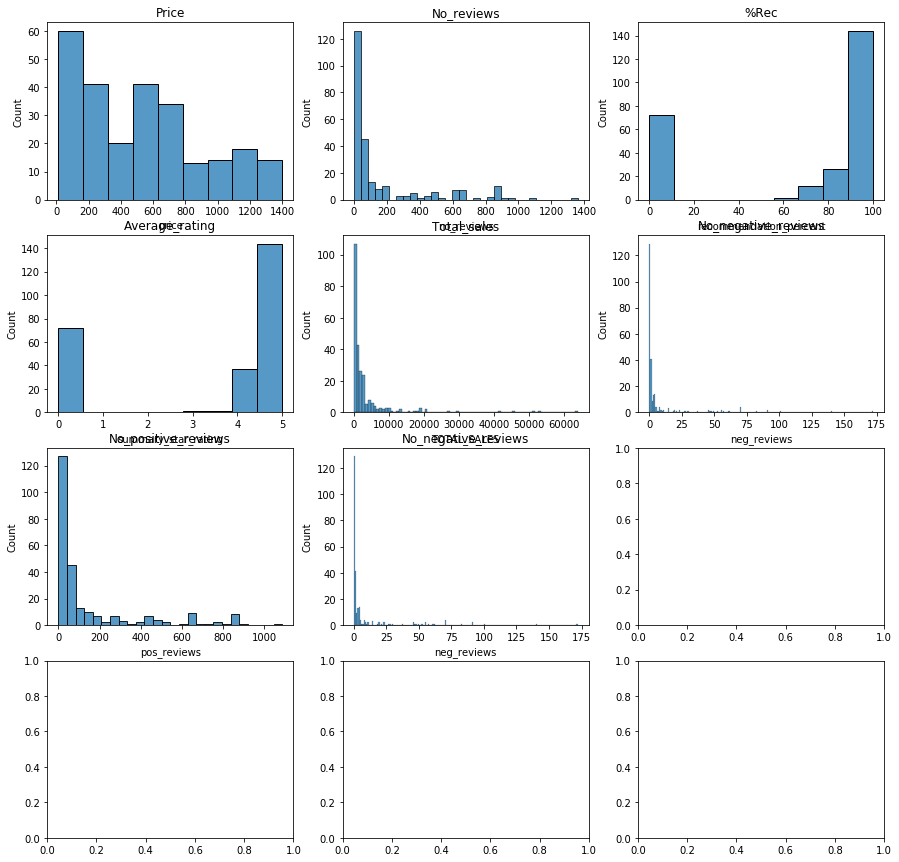

In [5]:
f, axes = plt.subplots(4,3, figsize=(15,15))
sns.histplot(df['price'].dropna(), ax=axes[0,0])
axes[0,0].set_title('Price')
sns.histplot(df['no_reviews'].dropna(), ax=axes[0,1])
axes[0,1].set_title('No_reviews')
sns.histplot(df['recommendation_percent'].dropna(), ax=axes[0,2])
axes[0,2].set_title('%Rec')
sns.histplot(df['summary_star_rating'].dropna(), ax=axes[1,0])
axes[1,0].set_title('Average_rating')
sns.histplot(df['TOTAL_SALES'].dropna(), ax=axes[1,1])
axes[1,1].set_title('Total_sales')
sns.histplot(df['neg_reviews'].dropna(), ax=axes[1,2])
axes[1,2].set_title('No_negative_reviews')
sns.histplot(df['neg_reviews'].dropna(), ax=axes[2,1])
axes[2,1].set_title('No_negative_reviews')
sns.histplot(df['pos_reviews'].dropna(), ax=axes[2,0])
axes[2,0].set_title('No_positive_reviews')
sns.histplot(df['price/Rvol'].dropna(), ax=axes[2,2])
axes[2,2].set_title('price/Rvol')
sns.histplot(df['negR/Rvol'].dropna(), ax=axes[3,0])
axes[3,0].set_title('negR/Rvol')
sns.histplot(df['c1'].dropna(), ax=axes[3,1])
axes[3,1].set_title('PCA_c1')
sns.histplot(df['c2'].dropna(), ax=axes[3,2])
axes[3,2].set_title('PCA_c2')

plt.tight_layout()

## Scaling

In [11]:
df.TOTAL_SALES.max()

63939

In [3]:
# 0 mean variance scaling, keeps NANS
sdf = df.select_dtypes(include=['float','int64'])
sdf['price/Rvol'] = sdf['price/Rvol'].replace(np.inf, sdf['price/Rvol'].median())
sdf = (sdf-sdf.mean())/sdf.std()
sdf['TOTAL_SALES'] = df['TOTAL_SALES']
sdf['TOTAL_SALES_BINNED'] = pd.cut(sdf['TOTAL_SALES'], [0,1000,10000,30000,65000], labels=[0,1,2,3])
sdf['TOTAL_SALES_QBINNED'] = pd.qcut(sdf['TOTAL_SALES'], 4, labels=[0,1,2,3])

## Kmeans - PCA

In [4]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

X=sdf[['c1','c2']]
km = KMeans(
    n_clusters=4, init='random',
    n_init=1000, max_iter=1000, 
    tol=1e-06, random_state=0
)
y_km = km.fit_predict(X)
sdf['KMeans'] = pd.Series(y_km, index=sdf.index)


(-1, 2)

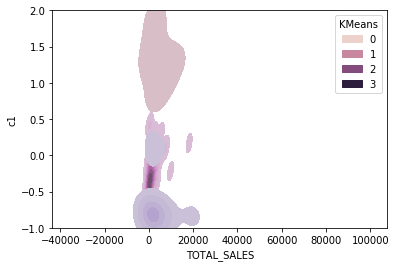

In [14]:
sns.kdeplot(x=sdf['TOTAL_SALES'].astype(int),y= sdf['c1'], hue=sdf['KMeans'] ,shade=True)
plt.ylim([-1,2])

In [10]:
sdf

,index,price,remotekey,shelf_order,summary_star_rating,TOTAL_SALES,neg_reviews,pos_reviews,price/Rvol,Rvol/%rec,posR/Rvol,negR/Rvol,index,c1,c2,TOTAL_SALES_BINNED,TOTAL_SALES_QBINNED,KMeans
0,-1.721886,-1.119432,-0.236987,-1.598110,0.639561,52704,0.667909,2.871703,-0.357477,2.013660,0.234249,-0.195934,-1.721886,2.079133,-0.003404,NaN,3,1
1,-1.708327,-0.727116,0.428386,-1.541234,0.592385,1785,-0.326246,-0.499864,-0.270723,-0.656031,-0.702661,-0.086767,-1.708327,-0.296111,-0.194386,2,2,2
2,-1.694769,-1.250100,-0.189430,-1.484358,0.262152,26758,7.401053,2.171390,-0.358157,3.180888,-2.666720,2.678496,-1.694769,4.191226,2.708138,NaN,3,0
3,-1.681211,-0.334695,0.640961,-1.427482,0.309328,63,-0.371435,-0.608895,4.007136,-0.766160,0.751971,-0.688570,-1.681211,-0.573259,-0.778655,0,0,2
4,-1.667653,-0.546520,0.109254,-1.370605,0.592385,12663,0.667909,1.445916,-0.352281,1.112947,-0.270986,0.106033,-1.667653,1.276268,0.034421,3,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250,1.667653,-0.857888,0.351501,-1.029348,0.639561,2636,-0.326246,-0.223094,-0.335996,-0.468762,0.399677,-0.494238,1.667653,-0.236078,-0.610244,2,2,2
251,1.681211,0.525811,0.337788,-0.972472,0.686737,24,-0.371435,-0.596315,1.630518,-0.756958,0.751971,-0.688570,1.681211,-0.486610,-1.091134,0,0,2
252,1.694769,1.964304,0.248552,-0.915596,0.356504,262,2.791787,1.433335,-0.337252,1.820007,-2.057707,1.320526,1.694769,2.330062,0.736551,1,0,0
253,1.708327,0.839664,0.248415,-0.858719,0.403680,301,0.035265,-0.369866,-0.241428,-0.432682,-2.244756,1.436785,1.708327,0.208754,0.391749,1,0,3


Silhouette score: 0.687098135139154


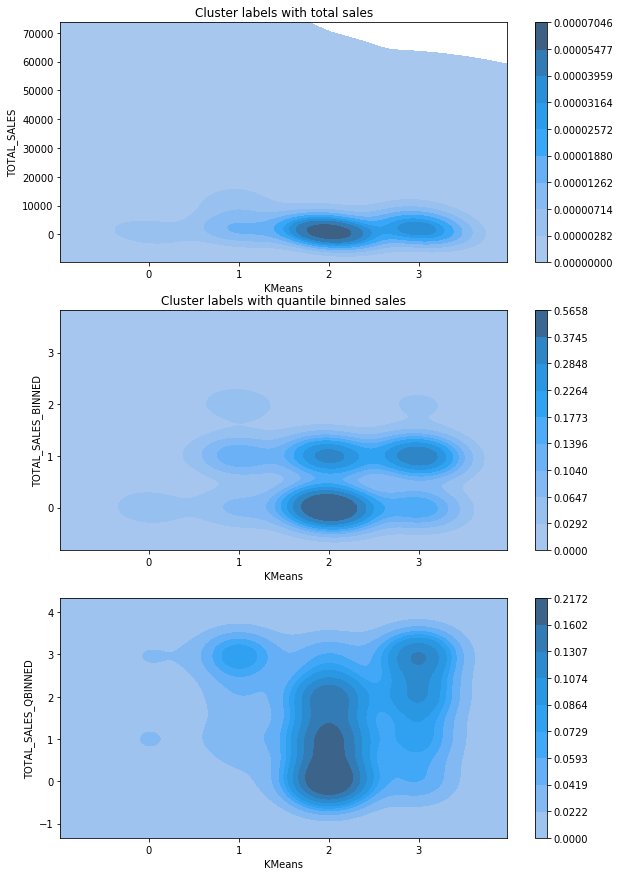

In [5]:
cluster_intelligence.evaluate_clusters(X, sdf['KMeans'] ,sdf['TOTAL_SALES'], sdf['TOTAL_SALES_BINNED'], sdf['TOTAL_SALES_QBINNED'])

## KMeans - PCA with outliers removal

In [ ]:
df.columns

Text(0.5,1,'Z-scores of primary comp')

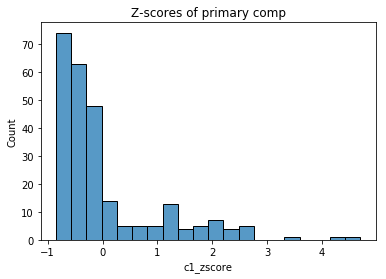

In [16]:
sdf = df.select_dtypes(include=['float','int64'])
sdf['TOTAL_SALES'] = df['TOTAL_SALES']
sdf['TOTAL_SALES_BINNED'] = pd.cut(sdf['TOTAL_SALES'], [0,200,800,3200,20000], labels=[0,1,2,3])
sdf['TOTAL_SALES_QBINNED'] = pd.qcut(sdf['TOTAL_SALES'], 4, labels=[0,1,2,3])
sdf['c1_zscore'] = (sdf['c1']-sdf['c1'].mean())/sdf['c1'].std()
X = sdf[['c1','c2']]
sns.histplot(sdf['c1_zscore'])
plt.title('Z-scores of primary comp')

Text(0.5,1,'Z-scores of primary comp')

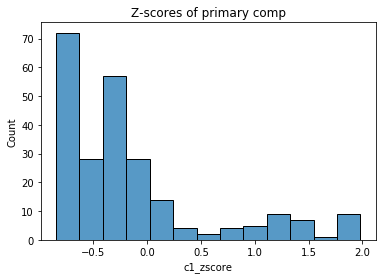

In [17]:
sdf = sdf.loc[sdf['c1_zscore'] <=2]
sns.histplot(sdf['c1_zscore'])
plt.title('Z-scores of primary comp')

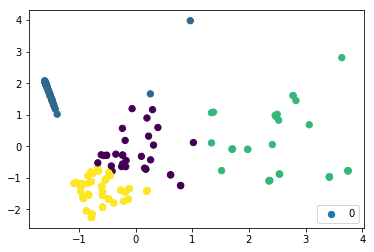

In [18]:
X=sdf[['c1','c2']]
km = KMeans(
    n_clusters=4, init='random',
    n_init=1000, max_iter=1000, 
    tol=1e-06, random_state=0
)
y_km = km.fit_predict(X)
sdf['KMeans'] = pd.Series(y_km, index=sdf.index)
plt.scatter(X['c1'], X['c2'], c=y_km, s=40, cmap='viridis')
plt.legend(y_km, loc=4)


ValueError: Cannot convert float NaN to integer

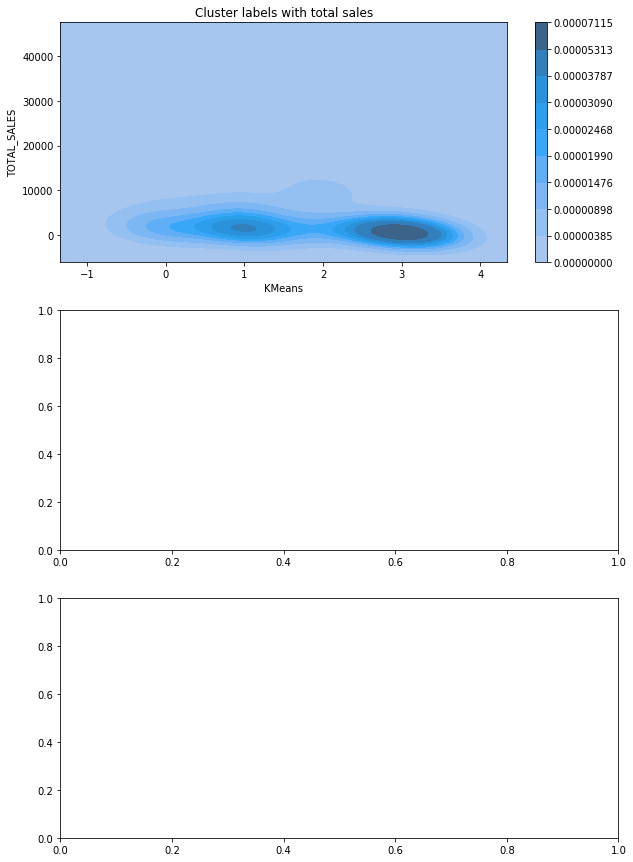

In [19]:
cluster_intelligence.evaluate_clusters(X, sdf['KMeans'] ,sdf['TOTAL_SALES'], sdf['TOTAL_SALES_BINNED'], sdf['TOTAL_SALES_QBINNED'])

(-1, 2)

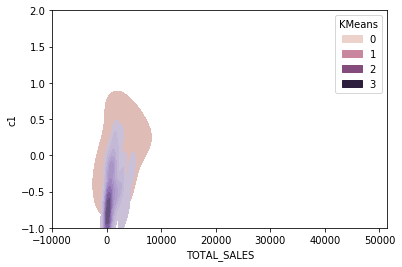

In [20]:
sns.kdeplot(x=sdf['TOTAL_SALES'].astype(int),y= sdf['c1'], hue=sdf['KMeans'] ,shade=True)
plt.ylim([-1,2])

## KMeans - Top 3 features

In [23]:
sdf=df[['no_reviews','Rvol/%rec','pos_reviews']]
sdf['Rvol/%rec'] = sdf['Rvol/%rec'].replace(np.nan, sdf['Rvol/%rec'].median())
sdf = (sdf-sdf.mean())/sdf.std()
sdf['TOTAL_SALES'] = df['TOTAL_SALES']
sdf['TOTAL_SALES_BINNED'] = pd.cut(sdf['TOTAL_SALES'], [0,1000,10000,30000,65000], labels=[0,1,2,3])
sdf['TOTAL_SALES_QBINNED'] = pd.qcut(sdf['TOTAL_SALES'], 4, labels=[0,1,2,3])
X = sdf[['no_reviews','Rvol/%rec','pos_reviews']]
km = KMeans(
    n_clusters=4, init='random',
    n_init=1000, max_iter=1000, 
    tol=1e-06, random_state=0
)
y_km = km.fit_predict(X)
sdf['KMeans'] = pd.Series(y_km, index=sdf.index)


Silhouette score: 0.7153343978073868


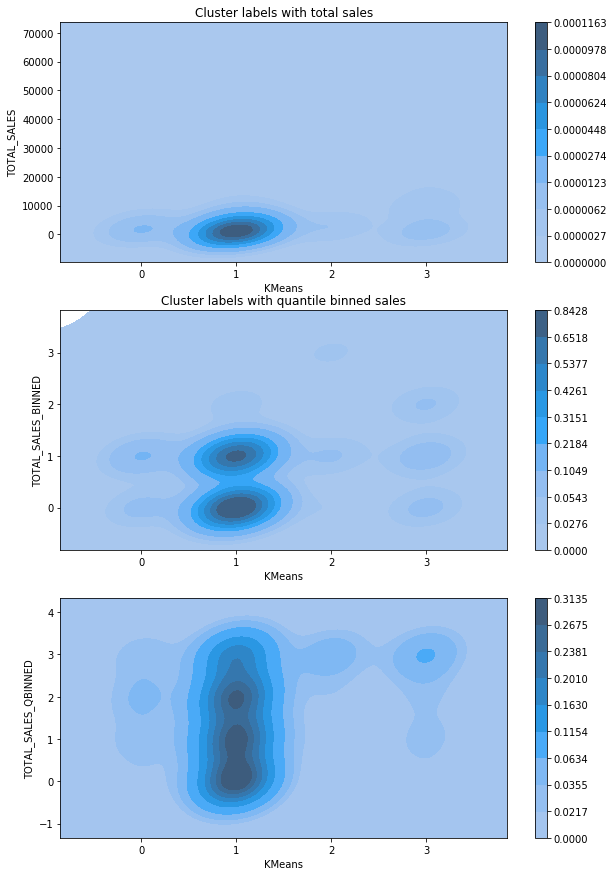

In [24]:
cluster_intelligence.evaluate_clusters(X, sdf['KMeans'],  sdf['TOTAL_SALES'], sdf['TOTAL_SALES_BINNED'], sdf['TOTAL_SALES_QBINNED'])


In [6]:
from modules import cluster_intelligence

cluster_intelligence.cluster_report(X, y_km, )

NameError: name 'y_km' is not defined

## KMeans top 3 features - outliers removed with price

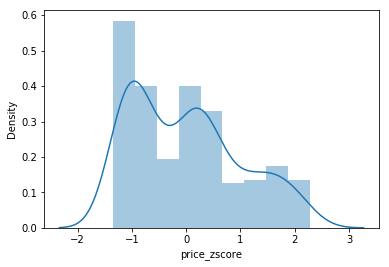

In [7]:
sdf=df[['no_reviews','Rvol/%rec','pos_reviews','price']]
sdf['price_zscore'] = (sdf['price']-sdf['price'].mean())/sdf['price'].std()
sns.distplot(sdf['price_zscore'])

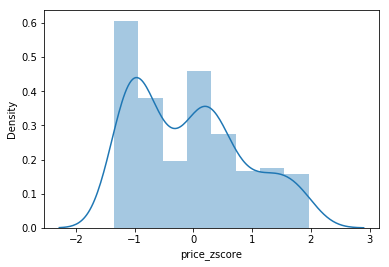

In [8]:
sdf = sdf.loc[(sdf['price_zscore'] >= -2)]
sdf = sdf.loc[(sdf['price_zscore'] <= 2)]
sdf['price_zscore'].max()
sns.distplot(sdf['price_zscore'])

In [9]:

sdf['Rvol/%rec'] = sdf['Rvol/%rec'].replace(np.nan, sdf['Rvol/%rec'].median())
sdf = (sdf-sdf.mean())/sdf.std()
sdf['TOTAL_SALES'] = df['TOTAL_SALES']
sdf['TOTAL_SALES_BINNED'] = pd.cut(sdf['TOTAL_SALES'],[0,1000,10000,30000,65000], labels=[0,1,2,3])
sdf['TOTAL_SALES_QBINNED'] = pd.qcut(sdf['TOTAL_SALES'], 4, labels=[0,1,2,3])
X = sdf[['no_reviews','Rvol/%rec','pos_reviews']]
km = KMeans(
    n_clusters=4, init='random',
    n_init=1000, max_iter=1000, 
    tol=1e-06, random_state=0
)
y_km = km.fit_predict(X)
sdf['KMeans'] = pd.Series(y_km, index=sdf.index)

Silhouette score: 0.710149248061494


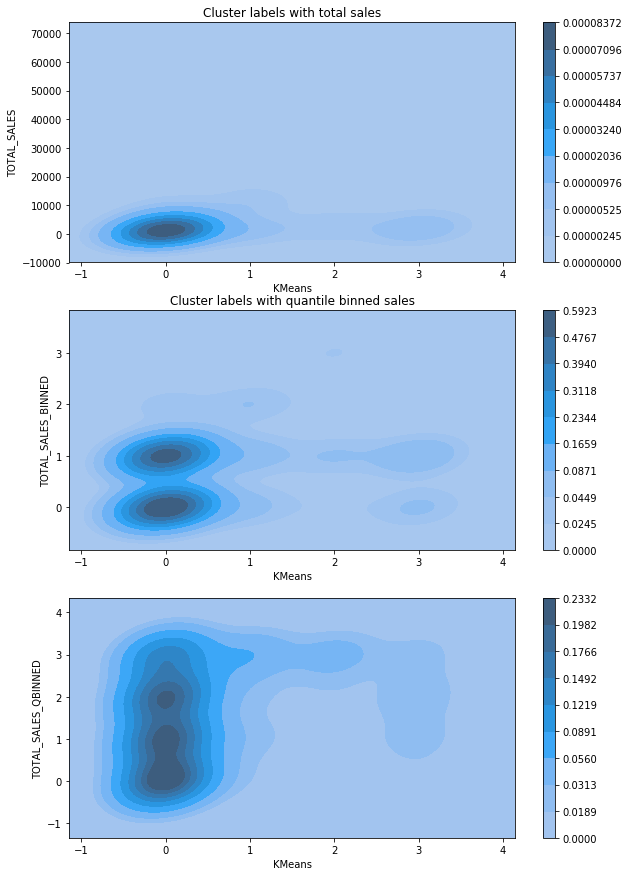

In [10]:
cluster_intelligence.evaluate_clusters(X, sdf['KMeans'] ,sdf['TOTAL_SALES'], sdf['TOTAL_SALES_BINNED'], sdf['TOTAL_SALES_QBINNED'])

In [ ]:
sdf

In [ ]:
cluster_intelligence.cluster_report(X, y_km, )

**These results are very nice indeed. Fucking result lads!.**

# Top 3 features - DBSCAN

Silhouette score: 0.7416396028462503


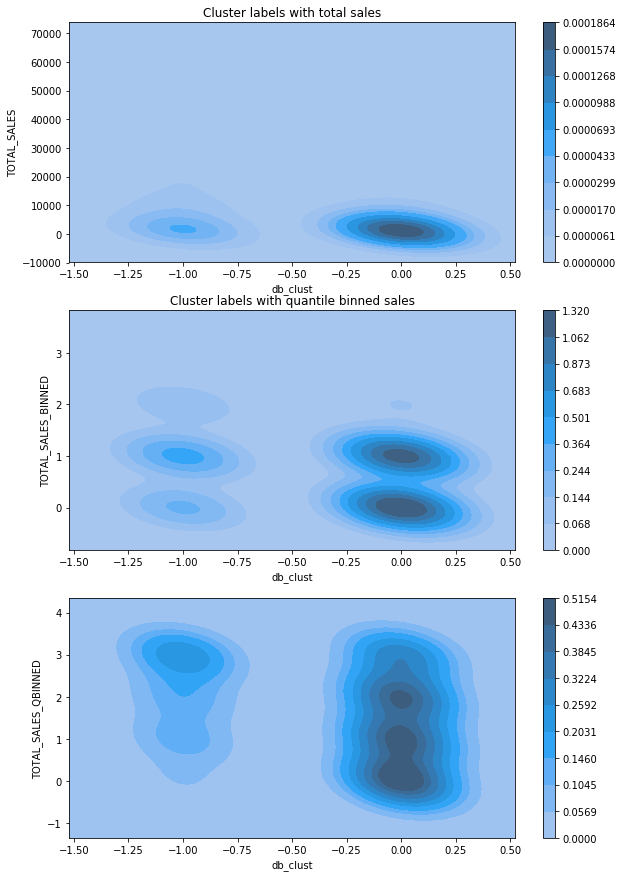

In [19]:
from sklearn.cluster import DBSCAN
from numpy import unique, where
from matplotlib import pyplot

# define the model
dbscan_model = DBSCAN(eps=0.25, min_samples=20)
# train the model
db_clust = dbscan_model.fit_predict(X)
sdf['db_clust'] = pd.Series(db_clust, index=sdf.index)
cluster_intelligence.evaluate_clusters(X, sdf['db_clust'] ,sdf['TOTAL_SALES'], sdf['TOTAL_SALES_BINNED'], sdf['TOTAL_SALES_QBINNED'])

In [20]:
cluster_intelligence.cluster_report(X, db_clust)

,class_name,instance_count,rule_list
1,-1,63,[1.0] (pos_reviews > -0.05948727764189243)
0,0,184,[1.0] (pos_reviews <= -0.05948727764189243)


In [22]:
sdf.loc[sdf.db_clust == 0]['TOTAL_SALES'].mean()

2323.9402173913045

In [16]:
sdf['TOTAL_SALES'].mean()

3799.6882591093117